In [7]:
# ライブラリを読み込みます（AIや画像処理をするための道具箱を使えるようにする）
import torch            # PyTorch本体
import torch.nn as nn   # ニューラルネットワーク用の部品
import torch.optim as optim   # 学習アルゴリズム（重みを調整する仕組み）
from torchvision import datasets, transforms, models  # 画像データや変換などのツール集
from torch.utils.data import DataLoader   # 画像を小分けにしてまとめて渡す道具

# 画像を同じ大きさにリサイズし、0〜1の範囲で扱えるように変換する（前準備）
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 画像の大きさを128×128に
    transforms.ToTensor()           # 0〜1の数値の配列に変換
])

# 学習用とテスト用の画像フォルダからデータを読み込む（パソコンのフォルダ名に合わせる）
train_data = datasets.ImageFolder(R"C:\work\mazda_ai_portfolio\dataset\metal_nut\metal_nut\train", transform=transform)
test_data = datasets.ImageFolder(R"C:\work\mazda_ai_portfolio\dataset\metal_nut\metal_nut\val", transform=transform)


# 画像データを8枚ずつまとめてメモリに取り込む（小分けにしてAIに渡すための仕組み）
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8)

# ニューラルネット（ここでは畳み込みニューラルネット：CNN）を自分で定義する
class SimpleCNN(nn.Module):  # AIの本体「型」を作る
    def __init__(self):
        super().__init__()  # 親クラスの初期化
        # 画像特徴を取り出す部分
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), # 入力3色→16個のフィルタ。小さい四角（3x3）で切り取る
            nn.ReLU(),                      # マイナスを0に、プラスはそのまま（活性化関数）
            nn.MaxPool2d(2, 2),             # 2×2の中で最大値だけ通す（サイズを半分に）
            nn.Conv2d(16, 32, 3, padding=1), # さらに32フィルタへ
            nn.ReLU(),
            nn.MaxPool2d(2, 2)              # さらに半分（合計で4分の1サイズに）
        )
        # 画像特徴→「どちらか」（良品／不良品）を決める部分
        self.fc = nn.Sequential(
            nn.Linear(32*32*32, 64),  # 32チャンネル×32×32画素→64個の数に縮める
            nn.ReLU(),
            nn.Linear(64, 2)          # 最後に2つ：ラベル（良品、不良品）のどちらか
        )

    def forward(self, x):    # 画像を渡されたとき処理するやり方を書く
        x = self.conv(x)     # 「特徴を抽出」部分
        x = x.view(-1, 32*32*32)  # 配列の形を1列に整える
        x = self.fc(x)       # 「結果を出す」部分に通す
        return x             # 結果（良品／不良品の可能性）を返す

# 作ったAIモデルの箱を用意する
model = SimpleCNN()  
# GPU（高速な計算機）があれば使う設定、なければ普通のCPUを使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # モデルを計算機に渡す

# AIがどれだけ間違えたか測る方法を決める（損失関数）、重みをどう調整するかも決める
criterion = nn.CrossEntropyLoss()  # 複数分類用の標準的な測り方
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 学習する方法

# ここからAIの「学習」を実行する（データを何回も見せて更新）
for epoch in range(10):  # 10回（エポック）くり返す
    running_loss = 0.0   # 各エポックの誤差を最初0にする
    for images, labels in train_loader:    # 8枚ずつ画像＆答えをもらう
        images, labels = images.to(device), labels.to(device)  # GPUまたはCPUに渡す

        optimizer.zero_grad()  # 前回の計算の残りをリセット
        outputs = model(images)  # 画像をモデルに入れて予測値を出す
        loss = criterion(outputs, labels)  # 予測と正解の差（損失）を計算
        loss.backward()                    # どこを直すべきか計算
        optimizer.step()                   # 計算結果にもとづいてモデルを少し修正
        running_loss += loss.item()        # 誤差を足し合わせる

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss:.4f}")  # 何回めで誤差がどれくらいか表示

# 学習したAIがどれだけ正しく答えられるかをテストする
correct = 0  # 正解数を0でリセット
total = 0    # 全体数も0でリセット
model.eval()  # 評価モード（途中で重み変更なし）
with torch.no_grad():         # 勝手に勾配を計算しないように
    for images, labels in test_loader:   # テスト画像を8枚ずつ処理
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)            # モデルで予測
        _, predicted = torch.max(outputs, 1)    # 予測結果の中で一番大きい番号＝予測ラベル
        total += labels.size(0)            # 全体のラベル数を足す
        correct += (predicted == labels).sum().item()  # 予測が当たったものを数える
print("Accuracy:", 100 * correct / total, "%")      # 正解率をパーセントで表示


Epoch [1/5], Loss: 18.0819
Epoch [2/5], Loss: 17.0806
Epoch [3/5], Loss: 17.6284
Epoch [4/5], Loss: 16.7282
Epoch [5/5], Loss: 16.7156
Epoch [6/5], Loss: 15.7735
Epoch [7/5], Loss: 15.3913
Epoch [8/5], Loss: 13.9562
Epoch [9/5], Loss: 13.9127
Epoch [10/5], Loss: 13.7717
Accuracy: 70.8029197080292 %


検証データの正解率: 0.7080
混同行列:
[[58 10]
 [30 39]]


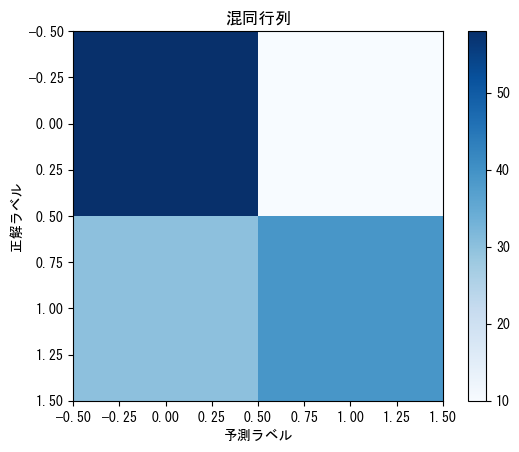

適合率： 0.7959183673469388
再現率： 0.5652173913043478
F値： 0.6610169491525424


In [8]:
import torch  # PyTorch本体
import torch.nn.functional as F  # 活性化関数など
from sklearn.metrics import confusion_matrix  # 混同行列計算用
import matplotlib.pyplot as plt  # 結果をグラフ化するため（任意）
import matplotlib
# 日本語を表示できるフォントに設定（Windowsなら例として'MS Gothic'）
matplotlib.rcParams['font.family'] = 'MS Gothic'  

model.eval()  # 評価モードに切り替え（学習時とは違い勾配計算しない設定）

all_preds = []  # 予測結果をためるリスト
all_labels = []  # 正解ラベルをためるリスト

with torch.no_grad():  # 勾配計算を止めて計算を軽くする
    for inputs, labels in test_loader:  # 検証用データをバッチで取得
        inputs, labels = inputs.to(device), labels.to(device)  # GPUに転送（deviceはモデルと同じ）
        outputs = model(inputs)  # モデルに入力して予測結果を得る
        probs = F.softmax(outputs, dim=1)  # 出力を確率に変換
        preds = torch.argmax(probs, dim=1)  # 一番高い確率のクラスを選ぶ
        all_preds.extend(preds.cpu().numpy())  # CPUに戻しリストに追加
        all_labels.extend(labels.cpu().numpy())  # 正解ラベルもリストに追加

# 正解率を計算
correct = sum(p == t for p, t in zip(all_preds, all_labels))
accuracy = correct / len(all_labels)
print(f"検証データの正解率: {accuracy:.4f}")

# 混同行列を計算・表示
cm = confusion_matrix(all_labels, all_preds)
print("混同行列:")
print(cm)

# （必要なら）混同行列をグラフで表示
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel("予測ラベル")
plt.ylabel("正解ラベル")
plt.title("混同行列")
plt.show()

# --- ここから改良例 ---
# ハイパーパラメータ調整やレイヤー追加は別途モデル定義部分で行い再学習します

# 例：学習率の変更
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

from sklearn.metrics import precision_score, recall_score, f1_score

print("適合率：", precision_score(all_labels, all_preds))
print("再現率：", recall_score(all_labels, all_preds))
print("F値：", f1_score(all_labels, all_preds))

# データ拡張例
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# ハイパーパラメータ変更例
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# 転移学習の微調整例
# model.fc = nn.Linear(in_features, num_classes)  # 最終層を置き換え
# 再び訓練ループで最適化
